In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

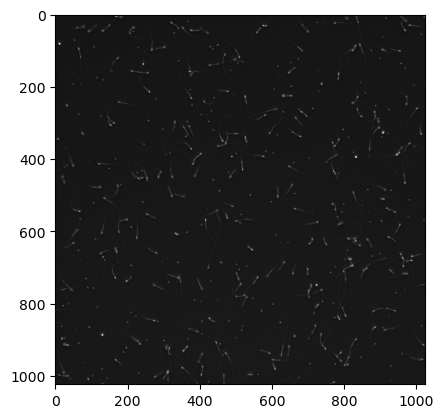

In [3]:
videofile = "ExampleVideos/10X_LD_1024_R1.avi"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

In [4]:
importlib.reload(tracker)
importlib.reload(utils)

bw2 = tracker.threshold(frame, method='hybrid')
_, label_im, stats, _ = cv2.connectedComponentsWithStats(bw2, 4, cv2.CV_32S)

# Seperate bbox from area
areas = stats[:,4]
bboxs = stats[:,0:4]

# Filter out the background (always index 0)
areas = areas[1:]
bboxs = bboxs[1:]
label_im -= 1


# Find centroids by focusing on heads
bw = tracker.threshold(frame, method='otsu')
kernel = np.ones((3,3),np.uint8)
bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
_, _, _, centroids = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S) 

# Filter out the background (always index 0)
centroids = centroids[1:]


In [5]:
def centroid_to_label(centroid, label_im):
    x,y = centroid
    r,c = int(y),int(x)
    if r < 0 or c < 0 or r >= label_im.shape[0] or c >= label_im.shape[1]:
        print("Warning: Centroid found out of bounds")
        return -1

    # Check the label of the four surrounding pixels    
    r2 = r+1 if r+1 < label_im.shape[0] else r
    c2 = c+1 if c+1 < label_im.shape[1] else c
    label_tl = label_im[r,c]
    label_tr = label_im[r,c2]
    label_bl = label_im[r2,c]
    label_br = label_im[r2,c2]
    
    if label_tl >= 0:
        label = label_tl
    elif label_tr >= 0:
        label = label_tr
    elif label_bl >= 0:
        label = label_bl
    else:
        label = label_br
        # TODO: Check mode of the four labels if they are greater than 1

    return label

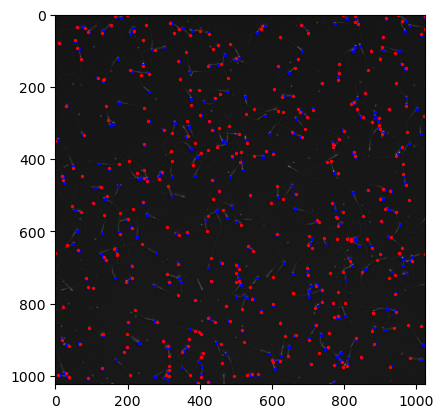

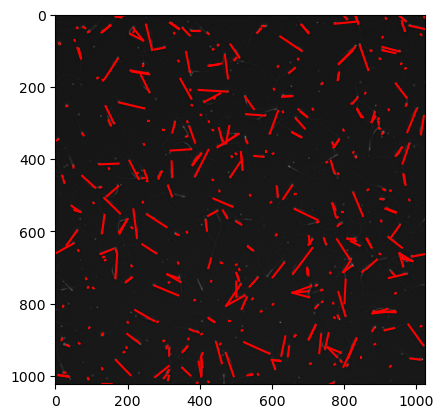

In [11]:
tail_points = np.zeros((len(centroids),2))

for i, centroid in enumerate(centroids):

    label = centroid_to_label(centroid, label_im)

    if label == -1:
        continue

    #cur_label = label_im == label

    pixels = np.where(label_im == label)

    # Find the farthest pixel for each centroid
    cur_dist = 0
    cur_pixel = None
    for p in range(len(pixels[0])):
        r = pixels[0][p]
        c = pixels[1][p]
        pixel = np.array([c,r])
        distance = np.linalg.norm(centroid - pixel)
        if distance > cur_dist:
            cur_dist = distance
            cur_pixel = pixel
    
    if cur_pixel is not None:
        tail_points[i] = cur_pixel
    else:
        print("Warning: No tail point found for centroid")

# Visualize the tail points
plt.imshow(frame)
plt.scatter(centroids[:,0], centroids[:,1], c='b', s=2)
plt.scatter(tail_points[:,0], tail_points[:,1], c='r', s=2)
plt.show()

# Visualize the connection as line segments
plt.imshow(frame)
for i in range(len(centroids)):
    plt.plot([centroids[i,0], tail_points[i,0]], [centroids[i,1], tail_points[i,1]], c='r')
plt.show()


In [29]:
def getAngle(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

def rotate(x_vals,y_vals,ang):
    x_vals_rot = x_vals*np.cos(ang) - y_vals*np.sin(ang)
    y_vals_rot = x_vals*np.sin(ang) + y_vals*np.cos(ang)
    return x_vals_rot, y_vals_rot

# Fit polynomial curve to segmentations between centroids and tail points
def fit_bezier(centroid, tail_point, label_im, debug=False):

    label = centroid_to_label(centroid, label_im)

    if label == -1:
        return None
    
    pixels = np.where(label_im == label)

    # Define transformation based on centroid and tail point
    translate = -centroid
    ang = -np.arctan2(tail_point[1] - centroid[1], tail_point[0] - centroid[0])

    if debug:
        plt.scatter(pixels[1], pixels[0], c='g', s=2)
        plt.show()

    # Rotate and translate the pixels
    x_vals = pixels[1] + translate[0]
    y_vals = pixels[0] + translate[1]

    x_vals_rot, y_vals_rot = rotate(x_vals, y_vals, ang)

    # Visualize the rotated pixels
    #plt.scatter(x_vals_rot, y_vals_rot, c='b', s=2)
    #plt.show()

    # Fit a polynomial curve to the rotated pixels
    coefs = np.polyfit(x_vals_rot, y_vals_rot, 3)

    # Draw the fitted curve
    curve_x = np.linspace(np.min(x_vals_rot), np.max(x_vals_rot), 100)
    curve_y = np.polyval(coefs, curve_x)
    
    if debug:
        plt.scatter(x_vals_rot, y_vals_rot, c='b', s=2)
        plt.plot(curve_x, curve_y, c='r')
        plt.show()

    return coefs

# Draw all bezier curves on frame
for i in range(len(centroids)):
    coefs = fit_bezier(centroids[i], tail_points[i], label_im, debug=False)
    if coefs is not None:
        dist = np.linalg.norm(centroids[i] - tail_points[i])
        curve_x = np.linspace(0, dist, 100)
        curve_y = np.polyval(coefs, curve_x)

        curve_x, curve_y = rotate(curve_x, curve_y, getAngle(centroids[i], tail_points[i]))
        curve_x += centroids[i][0]
        curve_y += centroids[i][1]

        plt.plot(curve_x, curve_y, c='r')




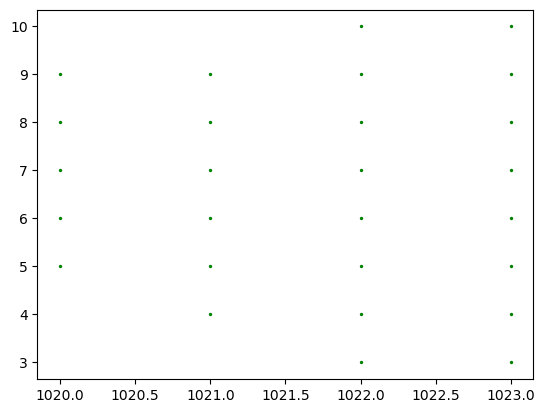

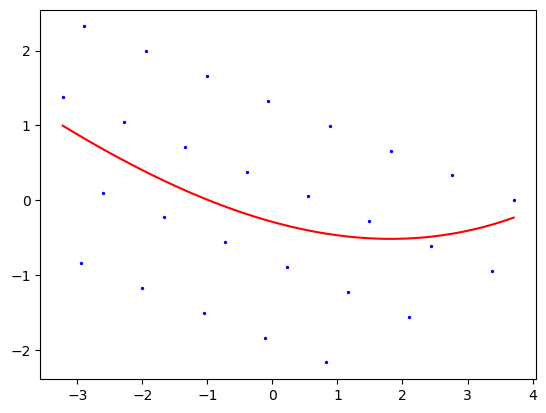

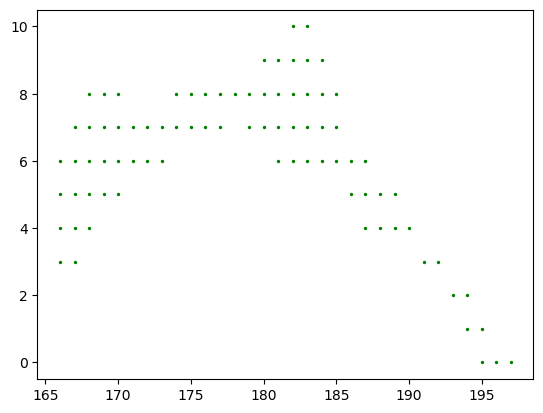

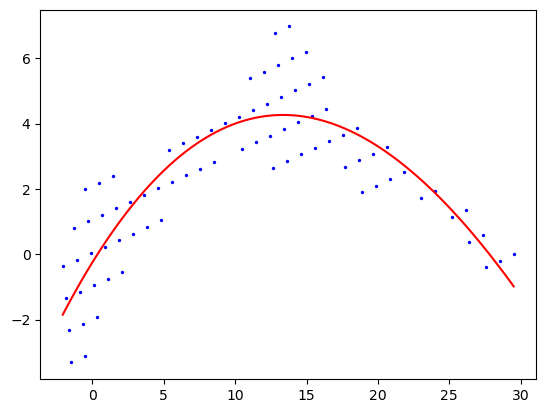

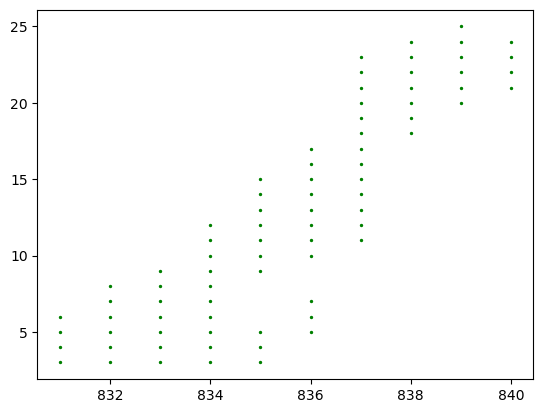

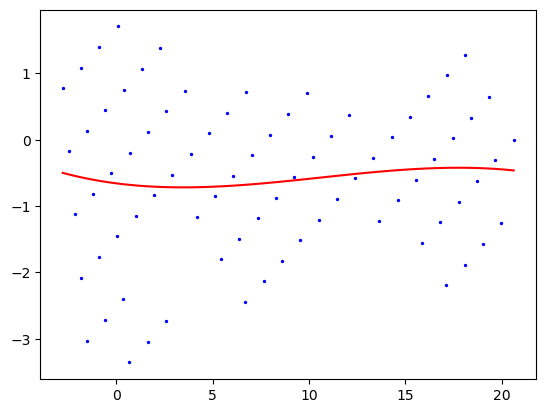

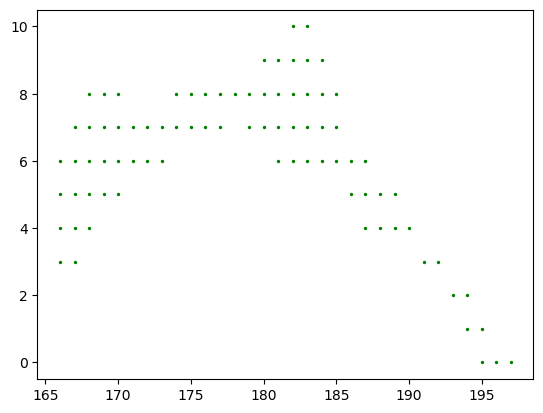

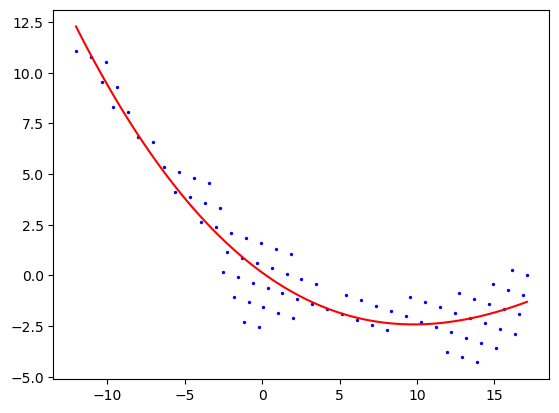

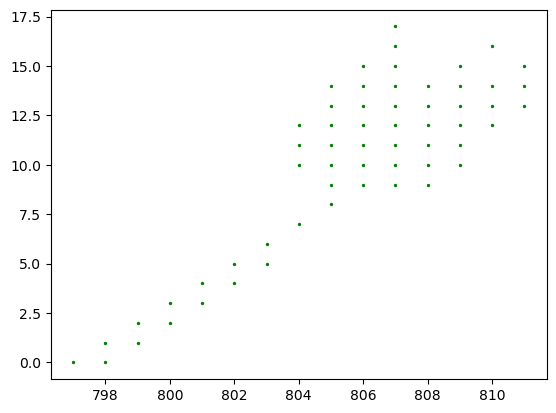

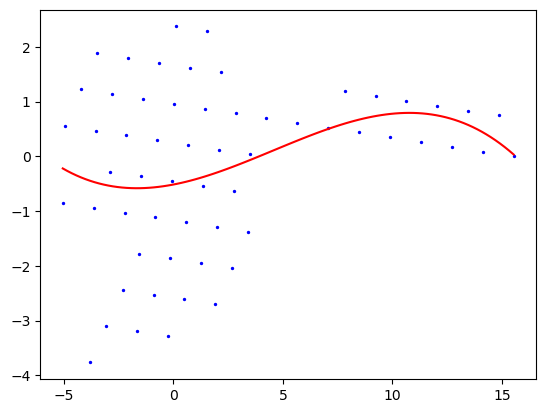

In [28]:
# Visualize the fitted curves
#for i in range(len(centroids)):
for i in range(5):
    coefs = fit_bezier(centroids[i], tail_points[i], label_im, debug=True)
    if coefs is not None:
        x_vals = np.linspace(0,frame.shape[1],100)
        y_vals = np.polyval(coefs, x_vals)
        x_vals += centroids[i,0]
        y_vals += centroids[i,1]
        #plt.plot(x_vals, y_vals, c='r')

### Feed through the tracking pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

final = tracker.segmentCells(frames, t)

print(final.head())

In [ ]:
utils.saveDataFrame(final, videofile.split('.')[0] + '_tracked.csv')

### Feed through the statistics pipeline

In [4]:
importlib.reload(stats)

final_withstats = stats.calcAverageSpeed(final)

print(final_withstats.head())

In [ ]:
utils.saveDataFrame(final_withstats, videofile.split('.')[0] + '_tracked_withstats.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final_withstats, visualization="segments")